In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import numpy as n
import os.path
import datetime as dt

sun_dist = 50e6#149.6e9
sun_ang = 0 # radians
sun_radius = 20e6
earth_size = 6.371e6

satellite_sizefactor = 5e6
altitude = 10e5 + earth_size # m
period = 90 # minutes
alpha = 0
zrot_period = 1 # minutes, period for spitroasting

Populating the interactive namespace from numpy and matplotlib


In [2]:

def update_location(obj, theta, r):
    obj.pos = vector(r * n.cos(theta), r  * n.sin(theta), 0)

def orbit_xyz(t, # time elapsed / period, 0 < t < 1
              alpha = 0, # 0 for ltdn = 12, pi/2 for ltdn = 6, -pi/2 < alpha < pi/2
              beta = 0, # 0 for 90 degree inclination
              altitude = 1,
             ):
    x = n.sin(t * 2 * n.pi) * n.cos(alpha) 
    y = n.cos(t * 2 * n.pi) * n.cos(beta) - \
        n.sin(t * 2 * n.pi) * n.sin(alpha) * n.sin(beta)
    z = - n.sin(t*2 * n.pi) * n.sin(alpha) * n.cos(beta) + \
        n.cos(t * 2 * n.pi) * n.sin(beta)
    
    return vector(altitude*x,altitude*y,altitude*z)
    
def get_theta(t, method = 'fast-pole-flip'):
    assert method in ['fast-pole-flip', 'slow-pole-flip', 'linear']
    
    #if method == 'linear':
    theta = (4 * n.pi * t)  
    if method == 'slow-pole-flip':
        theta -= n.sin(4*n.pi*t)
    elif method == 'fast-pole-flip':
        theta += n.sin(4*n.pi*t)
    
    return theta % (2*n.pi)

def get_zrot(t):
    # note that this t is not in the same scale as the ts above
    # this t is time_slice / period_zrot
    # other ts are curr_time / period
    # returns the amount of rotation 
    # for a constant rate of rotation it will return a constant
    return 2*n.pi * t
    

In [3]:
from vpython import *

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:

scene=canvas()

sun = sphere(pos=vector(0,sun_dist ,0) , radius=sun_radius, emissive=True,color=color.yellow)

earth = sphere(pos=vector(0,0,0), radius=earth_size, color=color.green, make_trail = False)

xy_plane = box(pos=vector(sun_dist/2, 0,0),length = sun_dist, width = 1, height = sun_dist, color=color.red, opacity = 0.2)
xy_plane.visible = False
scene.lights = []
# earth = sphere(pos=vector(0,0,0), radius=earth_size, color=color.green, make_trail = False)
# sun = sphere(pos=vector(sun_dist, 0 ,0) , radius=sun_radius, emissive=True,color=color.yellow)
sunlight = local_light(pos=vector(sun_dist , 0,0), color=color.gray(0.4))
scene.ambient = color.gray(0.5)
satellite = box(pos=vector(0,altitude, 0), length = 0.1*satellite_sizefactor, width = 0.1*satellite_sizefactor, height = 0.3*satellite_sizefactor, up = vector(0,1,0), make_trail = True)

In [5]:
xy_plane.visible=True
xy_plane.opacity = 0.6

In [7]:
satellite.clear_trail()
alpha = 0.4
beta = n.pi/4
n_points = 40 # number of simulation points per orbit

simtime = 5 #secs, simulation time of a single orbit
number_of_orbits = 1 # number of orbits to simulate

timeslice = period / (1.0 * n_points)
for i in linspace(0,number_of_orbits*period,number_of_orbits*n_points):
    rate(n_points/simtime)
    t = (i % period)*1.0/period
    
    
    new_pos = orbit_xyz(t, alpha, beta, altitude=altitude)
    #print (new_pos)
#     new_theta = get_theta(t, 'fast-pole-flip')
    satellite.pos = new_pos
#     satellite.up = orbit_xyz(new_theta/(2*n.pi), alpha)
#     zrot = get_zrot(timeslice / (1.0*zrot_period))
#     satellite.rotate(zrot, satellite.up)

### Orbits off the xy-plane (ltdn != 12)
Define the orbital plane using the angle $\alpha$, which in our case specifies an angle of rotation around the y-axis. 

From the description [here](https://math.stackexchange.com/questions/1742723/equation-of-a-circle-in-spherical-coordinates) we can paramterize the orbit on the x-y plane, and then apply the rotation matrix to it. So, first, the orbit on the xy plane where $ 0 \leq t < 2 \pi$ : 

$$
\begin{bmatrix}
x \\ y \\ z
\end{bmatrix} 
= 
\begin{bmatrix}
r \sin t \\ r \cos t \\ 0
\end{bmatrix}
$$

The rotation matrix for a rotation $\alpha$ around the y-axis is:

$$
\begin {bmatrix}
\cos \alpha & 0 & \sin \alpha \\
0 & 1 & 0 \\
- \sin \alpha & 0 & \cos \alpha
\end{bmatrix}
$$

So, multiply that by the parametric equation to get:
 
$$
\begin{bmatrix}
x \\ y \\ z
\end{bmatrix} 
= 
\begin{bmatrix}
r \sin t \cos \alpha \\ r \cos t \\ - r \sin t \sin \alpha
\end{bmatrix}
$$

The function `orbit_xyz` defined above does this operation. Based on the current time as a fraction of the period, and alpha, it gives back the x,y,z coordinates of the object. Note that the $t$ in the math above is between 0 and 2pi, but the t in the function is between 0 and 1 for convenience

### The flip
For now, we assume that the 'up' axis of the satellite will make an angle $\theta$ with the y-axis of our earth model. At $t = 0$, $\theta = 0$. At $t = 0.25$, we have $\theta = \pi$ since the satellite will be "upside down" when passing the equator. At $t = 0.5$, $\theta = 2\pi$. For the second half of the orbit, it loops around the same way.

Other than these points, the rate of change of $\theta$ is currently unclear. Few possible ways of modelling it:

* Linear : $\theta = 4 \pi t$
* Trigonometric, with fast flipping at the poles: 

$$
\frac{d\theta}{dt} \propto 1 + \cos(4\pi t) \\
\theta(t) = 4 \pi(t + \frac{1}{4\pi} \sin (4\pi t)) \\
\theta(t) = 4 \pi t + \sin (4\pi t))
$$

* Trigonometric, with slow flipping at the poles: 

$$
\frac{d\theta}{dt} \propto 1 - \cos(4\pi t) \\
\theta(t) = 4 \pi(t - \frac{1}{4\pi} \sin (4\pi t)) \\
\theta(t) = 4 \pi t - \sin (4\pi t))
$$


OK, so now we have a way of calculating the angle based on the current time. Now we need to convert this angle to a vector from the origin.

If we have a ltdn of 12 (alpha = 0), we can draw a unit circle on the xy-plane and based on a given $\theta$ we can calculate:

$$
\begin{bmatrix} x \\ y \\ z \end {bmatrix} = \begin{bmatrix} \sin \theta \\ \cos \theta \\ 0 \end {bmatrix}
$$

For cases where we have a non-zero $\alpha$, we can apply the rotation matrix to these coordinates to get basically the same exact formula:

$$
\begin{bmatrix}
x \\ y \\ z
\end{bmatrix} 
= 
\begin{bmatrix}
 \sin \theta \cos \alpha \\  \cos \theta \\ -  \sin \theta \sin \alpha
\end{bmatrix}
$$

Note the difference here - $\theta$ is a time-dependent quantity! So it's probably more correct to replace it with $\theta(t)$.

To calculate the "up" direction for the satellite, we will use the `get_theta` function defined above (with a few different options for the theta approximation). Since the math is essentially identical, to convert this theta into a vector we will use the `orbit_xyz` function. The only difference will be a factor of $2\pi$ in the inputs.

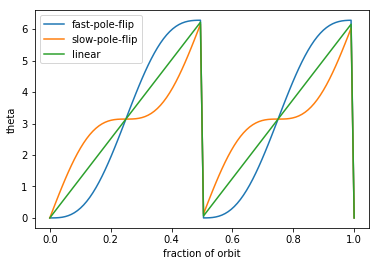

In [18]:
for method in ['fast-pole-flip', 'slow-pole-flip', 'linear']:
    thetas = []
    for i in n.linspace(0, 1, 100):
        thetas.append(get_theta(i, method))
    plot(n.linspace(0,1,100),thetas, label=method)
    xlabel('fraction of orbit')
    ylabel('theta')
    legend()
    

### Fixing the math to allow for inclination 
OK, we've defined $\alpha$ as the angle the orbital plane makes with the xy-plane we defined above. Reminder: xy-plane is defined as the plane containing the orbit with 90 degrees inclination. 

Even though we will have a set inclination of 98.6, let's generalize it anyways (for fun).

For convenience, let's use $\beta = i - 90$ where $i$ is the inclination. So our simple orbit with LTDN=12 and inclination=90 is defined as $\alpha=0, \beta=0$. Let's now define a time-dependent function that describes the rotation of the satellite, with the same convention as above, so using $0 \leq t < 2\pi$.

$$
f(t; \alpha, \beta) = R_{\alpha,\beta} \begin{bmatrix}
r \sin t \\ r \cos t \\ 0
\end{bmatrix}
$$


Here, $R_{\alpha,\beta}$ is the rotation matrix that will take points in a rotated orbit and map them to our original coordinate plane. 

Use [this](http://mathworld.wolfram.com/EulerAngles.html) description of Euler angles. In the image there, the first rotation (D) is not applicable in our case. 

Instead, use the general form of the rotation matrix for axis-angle rotations [here](https://en.wikipedia.org/wiki/Rotation_matrix#Rotation_matrix_from_axis_and_angle).

We'll describe the rotation as a composition of two rotations. The first rotation is around the x-axis to get the inclination, second is around the y-axis to get the ltdn. 

$$
R_{\alpha, \beta} = 
\begin {bmatrix}
\cos \alpha & 0 & \sin \alpha \\
0 & 1 & 0 \\
- \sin \alpha & 0 & \cos \alpha
\end{bmatrix}
\begin {bmatrix}
1 & 0 & 0 \\
0 & \cos\beta & \sin\beta \\
0 & -\sin\beta & \cos \beta
\end{bmatrix}
=
\begin {bmatrix}
\cos \alpha & -\sin \alpha \sin \beta & \sin \alpha \cos\beta \\
0 & \cos \beta & \sin \beta \\
- \sin \alpha & -\cos\alpha \sin\beta  & \cos \alpha \cos \beta
\end{bmatrix}
$$

So, let's bring it back to our function:

$$
f(t;\alpha, \beta) = r
\begin{bmatrix}
\sin t \cos \alpha - \cos t \sin \alpha \sin \beta \\
\cos t \cos \beta \\
- \sin t \sin \alpha + \cos t \cos \alpha \sin \beta
\end{bmatrix}
$$

OK, so the `orbit_xyz` function should be replace with that. In case we need it again, here's the pre-inclination version of the `orbit_xyz` function that only supports $\alpha$
```python
def orbit_xyz(t, # time elapsed / period, 0 < t < 1
              alpha, # 0 for ltdn = 12, pi/2 for ltdn = 6, -pi/2 < alpha < pi/2
              altitude = 1,
             ):
    x = n.sin(t * 2 * n.pi) * n.cos(alpha)
    y = n.cos(t * 2 * n.pi)
    z = - n.sin(t*2 * n.pi) * n.sin(alpha)
    
    return vector(altitude*x,altitude*y,altitude*z)
```

Did I mess up the order of multiplication? 

$$
\begin {bmatrix}
\cos \alpha & 0 & \sin \alpha  \\
- \sin \alpha \sin \beta & \cos \beta & \sin \beta \cos \alpha \\
- \sin \alpha \cos \beta & - \sin\beta  & \cos \alpha \cos \beta
\end{bmatrix}
\begin{bmatrix}
r \sin t \\ r \cos t \\ 0
\end{bmatrix} =  r
\begin{bmatrix}
\sin t \cos \alpha \\
- \sin t \sin \alpha \sin \beta + \cos t \cos\beta \\
-\sin t \sin \alpha \cos \beta - \cos t \sin \beta
\end{bmatrix}
$$

In [13]:
def orbit_xyz(t, # time elapsed / period, 0 < t < 1
              alpha = 0, # 0 for ltdn = 12, pi/2 for ltdn = 6, -pi/2 < alpha < pi/2
              beta = 0, # 0 for 90 degree inclination
              altitude = 1,
             ):
    x = n.sin(t * 2 * n.pi) * n.cos(alpha) 
    y = n.cos(t * 2 * n.pi) * n.cos(beta) - \
        n.sin(t * 2 * n.pi) * n.sin(alpha) * n.sin(beta)
    z = - n.sin(t*2 * n.pi) * n.sin(alpha) * n.cos(beta) + \
        n.cos(t * 2 * n.pi) * n.sin(beta)
    
    return vector(altitude*x,altitude*y,altitude*z)

In [15]:
# Flipped version

In [ ]:
# assume starting position at (0,1, 0)
# see math below about non-xy-plane orbits
def orbit_xyz(t, # time elapsed / period, 0 < t < 1
              alpha = 0, # 0 for ltdn = 12, pi/2 for ltdn = 6, -pi/2 < alpha < pi/2
              beta = 0, # 0 for 90 degree inclination
              altitude = 1,
             ):
    x = n.sin(t * 2 * n.pi) * n.cos(alpha) - \
        n.cos(t * 2 * n.pi) * n.sin(alpha) * n.sin(beta)
    y = n.cos(t * 2 * n.pi) * n.cos(beta)
    z = - n.sin(t*2 * n.pi) * n.sin(alpha) + \
        n.cos(t * 2 * n.pi) * n.cos(alpha) * n.sin(beta)
    
    return vector(altitude*x,altitude*y,altitude*z)